In [81]:
import os
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

#FIT FUNCTION
def f(x, a, b, c):
    return a+(b*np.exp(-c*x))

#GET SUMMARY INFO
def GetTARGETInfo(filename):
    Ntot = 1
    Ninteraction = 1
    density = 0
    target = ''
    energy = filename[filename.rfind("_")+1:filename.rfind("_")+3]
    tmp = 1e3
    f = open(filename, 'r')
    for i, line in enumerate(f):
        if i == 0:
            Ntot = float(line[line.find('->')+2:line.find('\n')])
        if i == 1:
            target = line[line.find('->')+2:line.find('\n')]
        elif i==2:
            density = float(line[line.find('->')+2:line.find('->')+2+5])
        elif line.find("protonInelastic") != -1:
            tmp = i
            Ninteraction = float(line[line.find('->')+2:line.find('\n')])
        elif i>tmp:
            break 
    f.close()
    return Ntot, Ninteraction, energy, target, density

def GetHISTOInfo(filename):
    energy = filename[filename.find("_")+1:filename.find("_")+3]
    data = pd.read_csv(filename, skiprows=7)
    MFP = data["0"]
    
    return energy, MFP

def GetPARTICLEInfo(filename):
    output = {}
    index = 1e3
    f = open(filename, 'r')
    for i, line in enumerate(f):
        if(line.find("START PARTICLES") != -1):
            index = i
        if i>index:
            output[line[:line.find("->")]] = float(line[line.find("->")+2:])
    f.close()
    
    return output
    

#MAIN ANALYSIS
#GET TRACKLENGHT FROM G4 FILES
MFP_Ene = pd.DataFrame() #dataframe[energy] = [histo of tracklegth]
MFP_Ene['Bins'] = list(range(1000))

density = 0
events = 1
N_pInel = {}
target = ''

#particles will be  a dictionary={energy:dictionary} of dictionaries
#at each energy is associated a dictionary={particle:counts}
particles = {}

files = os.listdir("../C12")
try:
    for filename in files:
            #FIND SUMMARY FILES
        if filename.find("SUMMARY") != -1:
            #GET TARGET INFO PER ENERGY
            events, inel, energy, target, density = GetTARGETInfo(filename)
            #GET PARTICLES COUNTS PER ENERGY
            particles[energy] = GetPARTICLEInfo(filename)
            #GET ProtonINELASTIC interaction
            N_pInel[energy] = inel
        #FIND HISTO FILES
        elif filename.find("HISTO") != -1:
            #GET HISTO OF TRACKLEGTH PER ENERGY
            energy, MFP = GetHISTOInfo(filename)
            MFP_Ene[energy] = MFP
except Exception: #SKIP ERRORS
    pass
    

print("****** SIMULATION INFO *****\n")
print("EVENTS:", events)
print("TARGET:", target)
print("DENSITY:", density, "g/cm3")


#FIT TRACKLEGHT HISTOS FOR CROSSS SECTIONS
XS = pd.DataFrame() #cross section dataframe, Energy, FitParameter, nonelastics-xs, etc.
vec_fitPar = list()
vec_energy = list()
for ene in MFP_Ene.columns:
    if ene != "Bins":
        #FIT
        popt, pcov = curve_fit(f, MFP_Ene["Bins"], MFP_Ene[ene]) 
        #GET EXPONENTIAL PARAMETER
        vec_fitPar.append(popt[2])
        if ene[1] == 'p':
            vec_energy.append(float(ene[0]))
        else:
            vec_energy.append(float(ene))
            
XS['Energy'] = vec_energy
XS['ExpFit'] = vec_fitPar

#From fit to Xs -> xs=l*A/(Na*Rho) [cm] -> xs*cmquad2barn_Na*1000 [mb]
cmquad2mbarn_Na = (1/6.022)*10 #factor from cm2 to barn per Avogadro number
Na = 6.022e23
A=1
if target == 'Y89':
    A=89
elif target =='Cu63':
    A=63
elif target =='C12':
    A=12
elif target =='O16':
    A=16
    
XS['Xs_nonelastic[mb]'] = XS['ExpFit']*A*cmquad2mbarn_Na*1000/density

****** SIMULATION INFO *****

EVENTS: 1
TARGET: 
DENSITY: 0 g/cm3


In [57]:
#GET LIGHT PARTICLES: GAMMA, NEUTRONS, PROTONS, ALPHAS
vec_pInelastic = list()
vec_gamma = list()
vec_proton = list()
vec_alpha = list()
vec_neutron = list()
vec_pg = list()
for ene in MFP_Ene.columns:
    if ene != "Bins":
        vec_pInelastic.append(N_pInel[ene])
        vec_gamma.append(particles[ene]["gamma"]) #GET GAMMA PER ENERGY
        try:
            vec_proton.append(particles[ene]["proton"]) #GET p PER ENERGY
        except:
            vec_proton.append(0.)
            
        try:
            vec_alpha.append(particles[ene]["alpha"]) #GET a PER ENERGY
        except:
            vec_alpha.append(0.)
            
        try:
            vec_neutron.append(particles[ene]["neutron"]) #GET n PER ENERGY
        except:
            vec_neutron.append(0.)
            
        try:
            if target == 'Y89':
                vec_pg.append(particles[ene]["Zr90"]) #GET Zr90 PER ENERGY
            elif target =='Cu63':
                vec_pg.append(particles[ene]["Zr90"]) #GET Zr90 PER ENERGY
            elif target =='C12':
                vec_pg.append(particles[ene]["Zr90"]) #GET Zr90 PER ENERGY
            elif target =='O16':
                vec_pg.append(particles[ene][""]) #GET Zr90 PER ENERGY
        except:
            vec_pg.append(0.)
            
        
XS['N_of_pInel'] = vec_pInelastic

XS['N_of_gamma'] = vec_gamma
XS['Xs_gamma[mb]'] = XS['Xs_nonelastic[mb]']*XS['N_of_gamma']/XS['N_of_pInel']

XS['N_of_proton'] = vec_proton
XS['Xs_proton[mb]'] = XS['Xs_nonelastic[mb]']*XS['N_of_proton']/XS['N_of_pInel']

XS['N_of_alpha'] = vec_alpha
XS['Xs_alpha[mb]'] = XS['Xs_nonelastic[mb]']*XS['N_of_alpha']/XS['N_of_pInel']

XS['N_of_nutron'] = vec_neutron
XS['Xs_neutron[mb]'] = XS['Xs_nonelastic[mb]']*XS['N_of_nutron']/XS['N_of_pInel']

XS['N_of_pg'] = vec_pg
XS['Xs_pg[mb]'] = XS['Xs_nonelastic[mb]']*XS['N_of_pg']/XS['N_of_pInel']

In [58]:
#TALYS XS
talyspath = "/Users/giorgio/Documents/PhD/PromptGamma/TALYS/"
xs_Y89 = {}
gSF_Y89_l1 = {}
xs_C12 = {}
gSF_C12_l1 = {}
if target == 'Y89':
    #Y89
    #nonelastic
    xs_Y89["nonel"] = np.loadtxt(talyspath+"Y89_p/output/nonelastic.tot")
    #neutron production
    xs_Y89["p,xn"] = np.loadtxt(talyspath+"Y89_p/output/nprod.tot")
    #proton production
    xs_Y89["p,xp"] = np.loadtxt(talyspath+"Y89_p/output/pprod.tot")
    #deuteron production
    xs_Y89["p,xd"] = np.loadtxt(talyspath+"Y89_p/output/dprod.tot")
    #alpha production
    xs_Y89["p,xa"] = np.loadtxt(talyspath+"Y89_p/output/aprod.tot")
    #gamma production
    xs_Y89["p,xg"] = np.loadtxt(talyspath+"Y89_p/output/gprod.tot")
    xs_Y89["p,g"] = np.loadtxt(talyspath+"Y89_p/output/rp040090.tot")
    #gamma strength function l=1
    gSF_Y89_l1["gSF"] = np.loadtxt(talyspath+"Y89_p/output/gSF-l1.tot")
elif target =='Cu63':
    #C12
    #neutron production
    xs_C12["p,xn"] = np.loadtxt(talyspath+"C12_p/output/nprod.tot")
    #proton production
    xs_C12["p,xp"] = np.loadtxt(talyspath+"C12_p/output/pprod.tot")
    #deuteron production
    xs_C12["p,xd"] = np.loadtxt(talyspath+"C12_p/output/dprod.tot")
    #alpha production
    xs_C12["p,xa"] = np.loadtxt(talyspath+"C12_p/output/aprod.tot")
    #gamma production
    xs_C12["p,xg"] = np.loadtxt(talyspath+"C12_p/output/gprod.tot")
    xs_C12["p,g"] = np.loadtxt(talyspath+"C12_p/output/rp007013.tot")
    #gamma strength function l=1
    gSF_C12_l1["gSF"] = np.loadtxt(talyspath+"C12_p/output/gSF-l1.tot")
elif target =='C12':
    A=12
elif target =='O16':
    A=16

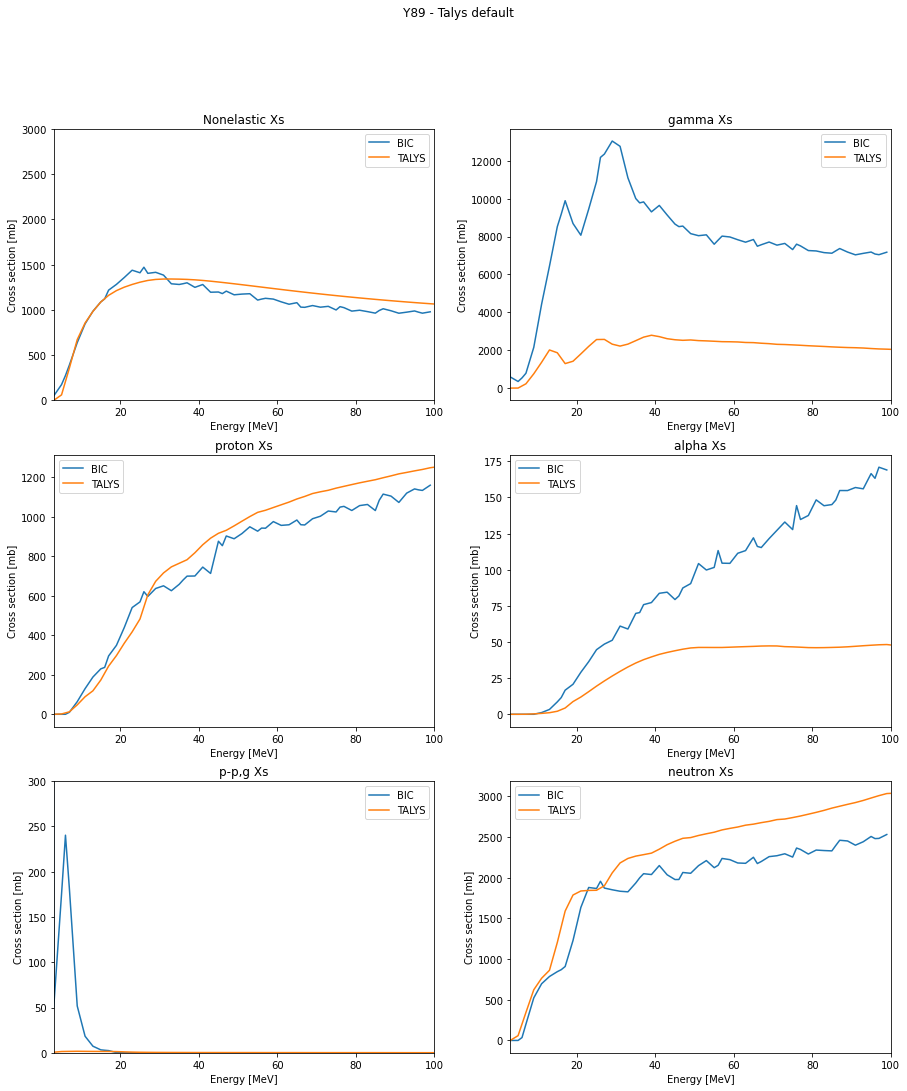

In [75]:
#----------Y89---------------------
fig, axs = plt.subplots(3,2, figsize=(15,17))
fig.suptitle('Y89 - Talys default')

#particles and gammas production xs - TALYS(default)
axs[0,0].plot(XS.sort_values(by='Energy')['Energy'], XS.sort_values(by='Energy')['Xs_nonelastic[mb]'], label='BIC')
axs[0,0].plot(xs_Y89["nonel"][:, 0], xs_Y89["nonel"][:, 1], label='TALYS')
axs[0,0].set_xlim(3,100)
axs[0,0].set_ylim(0,3000)

axs[0,0].set_xlabel("Energy [MeV]")
axs[0,0].set_ylabel("Cross section [mb]")
axs[0,0].set_title("Nonelastic Xs")
axs[0,0].legend()


#(p,g) vs total gamma production
#particles and gammas production xs - TALYS(default)
axs[0,1].plot(XS.sort_values(by='Energy')['Energy'], XS.sort_values(by='Energy')['Xs_gamma[mb]'], label='BIC')
axs[0,1].plot(xs_Y89["p,xg"][:, 0], xs_Y89["p,xg"][:, 1], label='TALYS')
axs[0,1].set_xlim(3,100)
#axs[0,1].set_ylim(0,3000)

axs[0,1].set_xlabel("Energy [MeV]")
axs[0,1].set_ylabel("Cross section [mb]")
axs[0,1].set_title("gamma Xs")
axs[0,1].legend()

#(p,) vs total gamma production
#particles and gammas production xs - TALYS(default)
axs[1,0].plot(XS.sort_values(by='Energy')['Energy'], XS.sort_values(by='Energy')['Xs_proton[mb]'], label='BIC')
axs[1,0].plot(xs_Y89["p,xp"][:, 0], xs_Y89["p,xp"][:, 1], label='TALYS')
axs[1,0].set_xlim(3,100)
#axs[0,1].set_ylim(0,3000)

axs[1,0].set_xlabel("Energy [MeV]")
axs[1,0].set_ylabel("Cross section [mb]")
axs[1,0].set_title("proton Xs")
axs[1,0].legend()

#(p,) vs total gamma production
#particles and gammas production xs - TALYS(default)
axs[1,1].plot(XS.sort_values(by='Energy')['Energy'], XS.sort_values(by='Energy')['Xs_alpha[mb]'], label='BIC')
axs[1,1].plot(xs_Y89["p,xa"][:, 0], xs_Y89["p,xa"][:, 1], label='TALYS')
axs[1,1].set_xlim(3,100)
#axs[0,1].set_ylim(0,3000)

axs[1,1].set_xlabel("Energy [MeV]")
axs[1,1].set_ylabel("Cross section [mb]")
axs[1,1].set_title("alpha Xs")
axs[1,1].legend()

#(p,) vs total gamma production
#particles and gammas production xs - TALYS(default)
axs[2,0].plot(XS.sort_values(by='Energy')['Energy'], XS.sort_values(by='Energy')['Xs_pg[mb]'], label='BIC')
axs[2,0].plot(xs_Y89["p,g"][:, 0], xs_Y89["p,g"][:, 1], label='TALYS')
axs[2,0].set_xlim(3,100)
axs[2,0].set_ylim(0,300)

axs[2,0].set_xlabel("Energy [MeV]")
axs[2,0].set_ylabel("Cross section [mb]")
axs[2,0].set_title("p-p,g Xs")
axs[2,0].legend()

#(p,) vs total gamma production
#particles and gammas production xs - TALYS(default)
axs[2,1].plot(XS.sort_values(by='Energy')['Energy'], XS.sort_values(by='Energy')['Xs_neutron[mb]'], label='BIC')
axs[2,1].plot(xs_Y89["p,xn"][:, 0], xs_Y89["p,xn"][:, 1], label='TALYS')
axs[2,1].set_xlim(3,100)
#axs[0,1].set_ylim(0,3000)

axs[2,1].set_xlabel("Energy [MeV]")
axs[2,1].set_ylabel("Cross section [mb]")
axs[2,1].set_title("neutron Xs")
axs[2,1].legend()

